<a href="https://colab.research.google.com/github/YoAkeHotaru/Erdos-Deep-Learning-2024-RAG-Project/blob/main/Embedding_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_json('/content/drive/MyDrive/Erdos_DL_2024/data/reddit.json')

In [ ]:
#Build a test data for the first ~1000 submission chunks
def get_test_data(data, length):
    j = 0
    for i in range(len(data)):
        if (i > length):
            if (data.iloc[i].reddit_title != None):
                j = i - 1
                break
        elif (i > length):
            j = i
            break
    return data.iloc[:j]

### Tree Structure

In [ ]:
class RedditNode:
    def __init__(self, data):
        self.type = data.aware_post_type
        self.subreddit = data.reddit_subreddit
        self.parent = data.reddit_parent_id
        self.id = data.reddit_name
        self.title = data.reddit_title
        self.text = data.reddit_text
        self.url = 'www.reddit.com' + data.reddit_permalink
        self.url2 = data.reddit_url
        self.next = []

    def is_submission(self):
        return self.title != None

    def link_next(self, node):
        self.next.append(node)

In [ ]:
class RedditTree:
    def __init__(self, df):
        self.df = df
        self.nodes = None
        self.roots = None
        self.build()

    def build(self):
        #Create a dictionary of data nodes and roots(submission)
        self.nodes = {}
        self.roots = {}

        for i in range(len(self.df)):
            #Build current RedditNode and add to dictionary
            data = self.df.iloc[i]
            node = RedditNode(data)
            self.nodes[node.id] = node

            #If the node is a comment, find and link with the parent
            if (data.reddit_parent_id != None):
                parent = self.nodes.get(data.reddit_parent_id)
                parent.link_next(node)
            #If the node is a submission, add to roots dict
            else:
                self.roots[node.id] = node

    #get the submission text and url link of the roots
    def get_submission(self):
        if self.nodes == None:
            return 'None object'
        res = []
        url = []
        for r in self.roots:
            res.append(self.roots.get(r).title + ' [SEP] ' + self.roots.get(r).text)
            url.append(self.roots.get(r).url)
        return res, url

    #get the comment text associated with the node
    def get_comments(self, node):
        if self.nodes == None:
            return 'None object'
        res = []
        for child in node.next:
            res.append(child.text)
        return res

In [ ]:
#Submissions in the test data
test = get_test_data(data, 100000)

In [ ]:
!pip install clean-text
!pip install abbreviations-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171034 sha256=a5623edf87bea0a447eadd5ff9ad2d226d1141517822314f97463c161a5db94b
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Preparing metadata (setup.py) ... done
  Created wheel for abbreviations-py: filename=abbreviations_py-0.2-py3-none-any.whl size=2945 sha256=c9e710741dc2251e21751c41bd99e77eccac6518559bc9095fe9a55a224648f6
  Stored in directory: /root/.cache/pip/wheels/0e/94/39/9d0b4fec8e8700d958c1647e1f0c080b97630d63ecab784481
Successfully built abbreviations-py


In [ ]:
import os
import json
import re
from cleantext import clean #Function to remove emojis

abb_path = '/content/drive/MyDrive/Erdos_DL_2024/'
abbreviation_file_path = os.path.join(abb_path, "abbreviation_mappings.json")

with open(abbreviation_file_path, "r") as json_file:
    abbreviation_mappings = json.load(json_file)

# Function to correct abbreviations:
# https://github.com/prajwalkhairnar/abbreviations_py/tree/main
def fix(text):
    """
    Fixes the abbreviated input text by replacing abbreviations, removing punctuations and hashtag terms.

    Parameters:
    text (str): The input abbreviated text to be fixed.

    Returns:
    str: The fixed text.
    """
    # Remove punctuations, emojis and hashtags
    text_punc = re.sub(r' *[<3#][^ ]* *', '', text)
    text_punc = re.sub(r'[^a-zA-Z0-9\']+', ' ', text_punc).strip()


    # Split text into words
    words = text_punc.split()

    # Convert words to lowercase
    normalized_words = [word.lower() for word in words]

    # Replace abbreviations with their full forms
    words_fixed = [abbreviation_mappings.get(word, word) for word in normalized_words]

    text_fixed = ' '.join(words_fixed)


    # Return processes string
    return text_fixed

# Function to remove emojis and correct abbreviations
def clean_text(text):
  text = clean(text)
  text = fix(text)
  return text

In [ ]:
data_tree = RedditTree(test)
submissions, urls = data_tree.get_submission()
len(submissions)
roots = data_tree.roots
roots = list(roots.values())
len(roots)

6376

## Construct a small test data set

In [ ]:
# Find the unique set of subreddit topics
topics = set()
for r in roots:
    topics.add(r.subreddit)
print('There are a total of ', len(topics), 'topics, they are: ')
print(topics, '\n')


topics = {'TjMaxx': [], 'Lowes': [], 'starbucksbaristas':[], 'starbucks':[], 'Fedexers':[], 'WalmartEmployees':[], 'DollarTree':[], 'UPSers':[], 'McLounge':[]}
for r in roots:
  if (r.subreddit in topics.keys()):
    topics[r.subreddit].append(r)

for t in topics.keys():
    print(len(topics[t]), t)

There are a total of  9 topics, they are: 
{'Fedexers', 'WalmartEmployees', 'UPSers', 'starbucksbaristas', 'McLounge', 'DollarTree', 'TjMaxx', 'Lowes', 'starbucks'} 

750 TjMaxx
612 Lowes
724 starbucksbaristas
857 starbucks
760 Fedexers
753 WalmartEmployees
760 DollarTree
578 UPSers
582 McLounge


In [ ]:
#np.random.seed(1337)

test_data = {}
cc = 0
for i, x in enumerate(topics.items()):
  if (cc > 100): break
  c = 0
  test_data[x[0]] = []
  for p in x[1]:
    if c >= 10: break
    if (len(p.next) >= 10 and p.url2[:24] == 'https://www.reddit.com/r'):
      c += 1
      cc += 1
      test_data[x[0]].append(p)

In [ ]:
cc = 1
for k, vals in test_data.items():
  print(k)
  for v in vals:
    print(f"{cc}. {v.id}:")
    cc += 1
    print(v.title)
    print(v.text)
    print(v.url)
    print()



TjMaxx
1. t3_12i2kyl:
who actually gets along with their managers?
If there is one thing that really annoys me is when managers one day talk to you as if you are besties and then suddenly one day or several they hardly even wanna speak to you or literally give you major attitude... 
happens to me therefor I just keep conversations to a minimum. (i'm also not the biggest extrovert) I'm not gonna sit and support your hot and cold attitude.
www.reddit.com/r/TjMaxx/comments/12i2kyl/who_actually_gets_along_with_their_managers/

2. t3_12hvgw6:
Autism speaks
Does anyone know if we've quietly cut ties with autism speaks? I haven't seen anything about it this month and I'm thinking we're far enough in April that I don't see us doing it. Just wondering if anyone knows for sure.
www.reddit.com/r/TjMaxx/comments/12hvgw6/autism_speaks/

3. t3_12h30ji:
Does every store check their associates bag before leaving?
Found this quite frustrating and mad annoyong as you are worrying about the wrong people 

In [ ]:
def to_chunk(data, max_len = 1000, min_len = 50, to_conversation = False, random = 0.33):
    # Input: data is a list of post nodes
    chunks = []
    posts = [] #store the post id
    comments = [] # store the comment id

    # for each post:
    for d in data:
        chunks.append(d.title + d.text)
        posts.append(d)
        comments.append(d)
        children = d.next #the list of top level comments to the post
        n_child = len(children)
        rand_content = [d.title, d.text, d.subreddit]  #used later to randomize
        text = []  #list to store temporary comments

        i = 0
        while i  < n_child:
            text.extend(helper(children[i], min_len, to_conversation))   #get all the comments in this node
            chunk = split_text(text, max_len)   #chunks for this comment
            chunk = randomize_chunk(chunk, min_len, random, rand_content)
            chunks.extend(chunk)
            posts.extend([d for _ in chunk])   #make sure posts match up with chunks
            comments.extend([children[i] for _ in chunk])
            text = []
            i = i + 1

    return posts, comments, chunks


# Helper function to construct list of texts
def helper(node, min_len = 50, to_conversation = False):
    # n_com = number of top level comments to include
    if (node == None):
        return None
    children = node.next
    if (children == None):
        return [node.text]

    res = []   #output is a list of comments
    text = node.text
    if (to_conversation):
        name = node.id
        res.append(name + ': ' + text)
    else:
        res.append(text)
    for c in children:
        res.extend(helper(c, to_conversation))

    return res


# Split the all the sub-comments within a top level comment according to max_len
def split_text(text_list, max_len):
    out = []   #output is a list of chunk(text)
    i = 0
    temp = ''
    while (i < len(text_list)):
        temp += text_list[i] + '[SEP]'
        if (len(temp) > max_len):
            out.append(temp)
            temp = ''
        i = i+1
    if len(temp) > 0 and temp != '[SEP]': out.append(temp)
    return out


# Randomly add title or text or subreddit topic to chunks with small length
def randomize_chunk(chunk, min_len, random, rand_content):
    # choices of randomized content
    title = rand_content[0]
    text = rand_content[1]
    subreddit = rand_content[2]
    for i in range(len(chunk)):
        r = np.random.rand(1)[0]  # get a random number in [0,1)
        # can modify whether to add title or not

        # augment the comment if it is too short
        # the main reason to augment is to retrieve relevant comment that are seemingly far away from the posts
        if (r < random and len(chunk[i]) < min_len):
            chunk[i] = title  + chunk[i]
        else:
            chunk[i] = chunk[i]
        chunk[i] = clean_text(chunk[i])
    return chunk

## Make chunks

In [ ]:
# hyperparameters to test out
max_len = [512]
min_len = 50
to_conversation = False
random = 0.1

# Construct various different chunks for embedding

# Store the different dataframes of context as a dictionary
# Keys: 'p, c'
def build_chunks(test_data, max_len, min_len, to_conversation, random):
    list_df = {}
    for m in max_len:
        posts = [] # store post id
        comments = [] # store comment id
        chunks = []
        for _, v in test_data.items():
            post, comment, chunk = to_chunk(v, m, min_len, to_conversation, random)
            posts.extend(post)
            comments.extend(comment)
            chunks.extend(chunk)
            #Construct dataframes
            key = str(m) + ',' + str(min_len)
            list_df[key] =  pd.DataFrame({'post': posts, 'comment': comments, 'chunk': chunks})
    return list_df

def add_id_col(node):
  return node.id

In [ ]:
# Inspect the details
list_df = build_chunks(test_data, max_len, min_len, to_conversation, random)
for k, v in list_df.items():
    print(f"Given chunk with {k.split(',')[0]} max_len and {k.split(',')[1]} min_len, there are {len(v)} items in total")

Given chunk with 512 max_len and 50 min_len, there are 2218 items in total


In [ ]:
# Add title and text if within range of length
''''
for df in list_df.values():
    for i, row in df.iterrows():
        title = df.at[i, 'node'].title
        text = df.at[i, 'node'].text
        #if (len(df.at[i, 'chunk']) + len(title) + len(text) < 1000):
        df.at[i, 'chunk'] = title + text + df.at[i, 'chunk']

In [ ]:
# add the node id column in order to calculate query search accuracy later on

for k, v in list_df.items():
    v['post_id'] = v['post'].apply(add_id_col)
    v['comment_id'] = v['comment'].apply(add_id_col)

In [ ]:
list_df['512,50'].head()

,post,comment,chunk,post_id,comment_id
0,<__main__.RedditNode object at 0x7f41fcc2ff40>,<__main__.RedditNode object at 0x7f41fcc2ff40>,who actually gets along with their managers?If...,t3_12i2kyl,t3_12i2kyl
1,<__main__.RedditNode object at 0x7f41fcc2ff40>,<__main__.RedditNode object at 0x7f41fcc2ff70>,i think it is important to understand that man...,t3_12i2kyl,t1_jfs6al1
2,<__main__.RedditNode object at 0x7f41fcc2ff40>,<__main__.RedditNode object at 0x7f41fcc2c160>,I am not besties with my managers but we are p...,t3_12i2kyl,t1_jfs78ic
3,<__main__.RedditNode object at 0x7f41fcc2ff40>,<__main__.RedditNode object at 0x7f41fcc2c100>,i enjoy my store manager love my merch manager...,t3_12i2kyl,t1_jfrsa1x
4,<__main__.RedditNode object at 0x7f41fcc2ff40>,<__main__.RedditNode object at 0x7f41fcc2c0d0>,current merch manager is a dream to work with ...,t3_12i2kyl,t1_jft84x9


# Create Embeddings in MongoDB

In [ ]:
!pip install sentence_transformers
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install sentence_transformers

In [ ]:
# Install below if using GPU
!pip install accelerate

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# https://huggingface.co/thenlper/gte-large
model_names = ["thenlper/gte-large", "all-MiniLM-L6-v2", "nq-distilbert-base-v1"]
embedding_model = SentenceTransformer("thenlper/gte-large")
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#embedding_model = SentenceTransformer("nq-distilbert-base-v1")

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

## Embedding Function:

In [ ]:
def get_embedding(text) -> list[float]:
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    embedding = embedding_model.encode(text)

    return embedding.tolist()

In [ ]:
#Create embedding column for each database
'''
for i, model in enumerate(model_names):
  embedding_model = SentenceTransformer(model)
  for _, v in list_df.items():
    embed_name = 'embedding' + str(i)
    v[embed_name] = v['chunk'].apply(get_embedding)

In [ ]:
!pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 19.6 MB/s eta 0:00:00


In [ ]:
import pymongo
from google.colab import userdata

def get_mongo_client(mongo_uri):
    """Establish connection to the MongoDB."""
    try:
        client = pymongo.MongoClient(mongo_uri)
        print("Connection to MongoDB successful")
        return client
    except pymongo.errors.ConnectionFailure as e:
        print(f"Connection failed: {e}")
        return None


mongo_uri = userdata.get("MONGO_URI")
if not mongo_uri:
    print("MONGO_URI not set in environment variables")
mongo_client = get_mongo_client(mongo_uri)

Connection to MongoDB successful


In [ ]:
# Ingest data into MongoDB

db = mongo_client["reddit"]

'''
for k, df in list_df.items():
      collection_name = "reddit_collection_multiple_embed_final"
      collection = db[collection_name]
      collection.delete_many({})
      df = df.drop(columns = ['post', 'comment'])
      documents = df.to_dict("records")
      collection.insert_many(documents)

In [ ]:
db = mongo_client["reddit"]

In [ ]:
def vector_search(user_query, collection, index, embedding_path = 'embedding0', k = 10):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    pipeline = [
        {
            "$vectorSearch": {
                "index": index,
                "queryVector": query_embedding,
                "path": embedding_path,
                "numCandidates": 150,  # Number of candidate matches to consider
                "limit": k,  # Return top k matches
            }
        },
        {
            "$project": {
                "_id": 0,
                "post_id": 1,  # Include the post id
                "comment_id": 1, # Include the comment id
                "chunk": 1,  # Include the chunk
                "score": {"$meta": "vectorSearchScore"},  # Include the search score
            }
        },
    ]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)


In [ ]:
def get_search_result(query, collection, index, embedding_path = 'embedding0',  k = 10):
    get_knowledge = vector_search(query, collection, index, embedding_path,  k)
    search_result = ""
    id_result = []
    for result in get_knowledge:
        id = result.get('post_id')
        chunk = result.get('chunk')
        search_result += f"Text: {chunk}\n"
        id_result.append(id)
    return search_result, id_result

# Another version to get the search result
def get_search_result_context(query, collection, index, embedding_path = 'embedding0', k = 10):
    get_knowledge = vector_search(query, collection, index, embedding_path, k)
    search_result = []
    id_result = []
    score_result = []
    for result in get_knowledge:
        id = result.get('post_id')
        chunk = result.get('chunk')
        score = result.get('score')
        search_result.append(chunk)
        id_result.append(id)
        score_result.append(score)
    return search_result, id_result, score_result

In [ ]:
# This cell is used below in the llm section
db = mongo_client["reddit"]
query = "What does dollartree employee worry about?"
source_information, id_result = get_search_result(query, db['reddit_collection_multiple_embed_final'], 'vector_index_0', 'embedding0', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

Query: What does dollartree employee worry about?
Continue to answer the query by using the Search Results:
Text: you have every right to talk people talk all the time about their jobs and especially this job its not some top secret work at nasa its dollar tree where you are minimally paid employees it sounds to me like he knows that a lot of shady stuff is going down on dollar tree and thinks he can control you from speaking up if something is not right speak on it sep
Text: dollar treeonly closed on christmas day or in case of thermonuclear war in which case the product may be irradiated and the associates may have radiation sickness when they re open the next day sep
Text: I have always thought i hated myself until i realized i am kind enough to myself to not take the manager position here at dollar tree overworked underpaid I have witnessed three of my managers cry at different times due to being fucked over by upper management sep they are always with the empty promises to move up

# Evaluating chunk size


 Modified Recall = $\displaystyle\frac{\text{Number of True Positive}}{\text{min(D, N)}}$

In [ ]:
# Create a list of collections
collections = ['reddit_collection_multiple_embed_final']
# for k, df in list_df.items():
#   collection_name = "reddit_collection_" + k.split(',')[0] + '_' + k.split(',')[1]
#   collections.append(collection_name)

In [ ]:
collections

['reddit_collection_multiple_embed_final']

In [ ]:
# count the number of chunk with given post id
# id = 't3_11zknh2'
# count = db['reddit_collection_256_50'].count_documents({'post_id' : id})
# count

### Question generation

In [ ]:
from transformers import T5Config, T5ForConditionalGeneration, T5Tokenizer

model_name = "allenai/t5-small-squad2-question-generation"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def run_model(input_string, **generator_args):
    input_ids = tokenizer.encode(input_string, return_tensors="pt")
    res = model.generate(input_ids, **generator_args)
    output = tokenizer.batch_decode(res, skip_special_tokens=True)
    print(output)
    return output


run_model("shrouds herself in white and walks penitentially disguised as brotherly love through factories and parliaments; offers help, but desires power;")
run_model("He thanked all fellow bloggers and organizations that showed support.")
run_model("Races are held between April and December at the Veliefendi Hippodrome near Bakerky, 15 km (9 miles) west of Istanbul.")


tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['What is the name of the man who is a brotherly love?']
['What did He thank all fellow bloggers and organizations that showed support?']
['Where is the Veliefendi Hippodrome located?']


['Where is the Veliefendi Hippodrome located?']

In [ ]:
text = '''
Inclusions on the side? A lady came in yesterday and tried to order a grande strawberry açaí refresher, with 10 scoops of strawberry, on the side. I told her we can’t do that, because it’s selling beverage components separately, which we cannot do by standard. Was I wrong? She insisted that every Starbucks always does it for her. Is there somewhere in the BRM that says that we can’t do this? (If not, please let me know if I was wrong so I don’t make the mistake again!) thanks!
'''
run_model(text)

["What is the name of the Starbucks that says that we can't do this?"]


["What is the name of the Starbucks that says that we can't do this?"]

In [ ]:
test_questions = {}
for key, val in test_data.items():
  test_questions[key] = []
  for v in val:
    test_questions[key].append(run_model(v.title + '[SEP]' + v.text))

In [ ]:
for key, val in test_questions.items():
  for i, v in enumerate(val):
    print(v)
    p = test_data[key][i]
    print(p.title + '[SEP]' + p.text)

In [ ]:
for k,v in test_questions.items():
  print(k)

512,50


In [ ]:
# Counter is needed because MongoDB vector search index has a limit of 3, so cannot perform search for all collections at a time...
'''
def predict(collections, k = 10):
  counter = 1
  for c in collections:
    if (counter > 1): break
    total_correct = 0
    total = 0
    collection = db[c]
    print('Collection: ' + c + '\n')
    for keys, vals in test_data.items():
      print('Topic is: ' + keys)
      for v in vals:  #for every post, compute the accuracy
        query = v.title + v.text # query is the combined context of submission
        search_result, id_result = get_search_result(query, collection, c, k)
        correct = 0
        for i in id_result:
          if (i == v.id):
            correct += 1
        print(f"Post {v.id} accuracy is {correct/k}" )
        total_correct += correct
        total += k
    print(f"Collection: {c} has accuracy: {total_correct/total} \n")
    counter += 1

# Predict a single collection
def predict_one(collection_name, k = 10):
  total_correct = 0
  total = 0

  collection = db[collection_name]
  print('Collection: ' + collection_name + '\n')
  for keys, vals in test_data.items():
    total_recall = 0
    topic_correct = 0
    print('Topic is: ' + keys)
    for v in vals:  #for every post, compute the accuracy and recall
      num_chunk = collection.count_documents({'post_id' : v.id})  #this is the number of chunks in the database
      #num_chunk = collection.count_documents({'id' : v.id})
      query = v.title + v.text # query is the combined context of submission
      search_result, id_result = get_search_result(query, collection, collection_name, k)
      correct = 0
      recall = 0
      for i in id_result:
        if (i == v.id):
          topic_correct += 1
          correct += 1
      if (num_chunk == 0):
        recall = 1
      else:
        recall = correct/min(num_chunk, k)
      print(f"Post {v.id} has accuracy {correct}/{k} = {correct/k} and recall {correct}/{min(num_chunk, k)}={round(recall,2)}" )
      total_correct += correct
      total_recall += recall #This can be computed in a different way, namely, a weighted average
      total += k
    print(f"Topic {keys} has average accuracy: {topic_correct}/{k*10} = {topic_correct/(k*10)}, has average recall {total_recall/10}")
  #print(f"Collection: {collection_name} has accuracy: {total_correct}/{total} = {total_correct/total} \n")


## Predict function

In [ ]:
def predict(collection_name, model_number, k = 10, print_eval = True):
  ii = 1
  precisions = []
  m_recalls = []
  recalls = []
  m_fones = []
  fones = []
  total_correct = 0
  #total_retrieved = 0
  collection = db[collection_name]
  print('Collection: ' + collection_name + '\n')

  for keys, vals in test_data.items():
    topic_num = 0
    topic_m_recall = 0
    topic_recall = 0
    topic_chunk = 0
    topic_correct = 0
    topic_m_f1 = 0
    topic_f1 = 0
    print('Topic is: ' + keys)

    for v in vals:  #for every post, compute the accuracy and recall
      num_chunk = collection.count_documents({'post_id' : v.id})  #this is the number of chunks in the database
      topic_chunk += num_chunk
      topic_num += 1
      query = v.title + v.text # query is the combined context of submission
      search_result, id_result, score_result = get_search_result_context(query, collection, 'vector_index_' + str(model_number), 'embedding' + str(model_number), k)

      correct = 0
      m_recall = 0
      recall = 0
      for i in id_result:
        if (i == v.id):
          topic_correct += 1
          correct += 1

      precision = correct/k
      m_recall = correct/min(num_chunk, k)
      recall = correct/num_chunk
      m_fone = 2/((1/precision) + (1/m_recall))
      fone = 2/((1/precision) + (1/recall))

      #recall = correct/num_chunk
      m_recalls.append(m_recall)
      recalls.append(recall)
      precisions.append(precision)
      m_fones.append(m_fone)
      fones.append(fone)

      topic_m_recall += m_recall
      topic_recall += recall
      topic_m_f1 += m_fone
      topic_f1 += fone

      if (print_eval == True): print(f"{ii}. Post {v.id} has {num_chunk} documents. It has precision {correct}/{k} = {round(precision,2)}, modified recall {correct}/{min(num_chunk, k)}={round(m_recall,2)}, recall {correct}/{num_chunk}={round(recall,2)}, modiefied f1 score {round(m_fone, 2)}, f1 score {round(fone, 2)}" )
      ii += 1
      #total_retrieved += k

    print(f"Topic {keys} has average precision: {topic_correct}/{topic_num*k} = {round(topic_correct/(topic_num*k), 2)}, has average modified recall {round(topic_m_recall/topic_num, 2)}, has average recall {round(topic_recall/topic_num, 2)}, has average modiefied f1 score {round(topic_m_f1/topic_num, 2)}, has average f1 score {round(topic_f1/topic_num, 2)}")
  return precisions, m_recalls, recalls, m_fones, fones



### 40 Retrieval

In [ ]:
all_precision = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
for i, model in enumerate(model_names):
  print(model)
  embedding_model = SentenceTransformer(model)
  all_precision[model], all_m_recall[model], all_recall[model], all_m_f1[model], all_f1[model] = predict('reddit_collection_multiple_embed_final', i, 40)

thenlper/gte-large
Collection: reddit_collection_multiple_embed_final

Topic is: TjMaxx
1. Post t3_12i2kyl has 16 documents. It has precision 14/40 = 0.35, modified recall 14/16=0.88, recall 14/16=0.88, modiefied f1 score 0.5, f1 score 0.5
2. Post t3_12hvgw6 has 16 documents. It has precision 14/40 = 0.35, modified recall 14/16=0.88, recall 14/16=0.88, modiefied f1 score 0.5, f1 score 0.5
3. Post t3_12h30ji has 20 documents. It has precision 13/40 = 0.33, modified recall 13/20=0.65, recall 13/20=0.65, modiefied f1 score 0.43, f1 score 0.43
4. Post t3_12f50sz has 17 documents. It has precision 15/40 = 0.38, modified recall 15/17=0.88, recall 15/17=0.88, modiefied f1 score 0.53, f1 score 0.53
5. Post t3_12bvdks has 11 documents. It has precision 10/40 = 0.25, modified recall 10/11=0.91, recall 10/11=0.91, modiefied f1 score 0.39, f1 score 0.39
6. Post t3_12a5q6d has 22 documents. It has precision 11/40 = 0.28, modified recall 11/22=0.5, recall 11/22=0.5, modiefied f1 score 0.35, f1 score

In [ ]:
print("Number of Retrieval: 40\n")
for k,v in all_precision.items():
  print(f"Model {k} has average precision {round(np.mean(v),2)}")
print()
for k,v in all_m_recall.items():
  print(f"Model {k} has average modified recall {round(np.mean(v),2)}")
print()
for k,v in all_recall.items():
  print(f"Model {k} has average recall {round(np.mean(v),2)}")
print()
for k,v in all_m_f1.items():
  print(f"Model {k} has average modified f1 score {round(np.mean(v),2)}")
print()
for k,v in all_f1.items():
  print(f"Model {k} has average f1 score {round(np.mean(v),2)}")

Number of Retrieval: 40

Model thenlper/gte-large has average precision 0.35
Model all-MiniLM-L6-v2 has average precision 0.32
Model nq-distilbert-base-v1 has average precision 0.18

Model thenlper/gte-large has average modified recall 0.63
Model all-MiniLM-L6-v2 has average modified recall 0.56
Model nq-distilbert-base-v1 has average modified recall 0.32

Model thenlper/gte-large has average recall 0.6
Model all-MiniLM-L6-v2 has average recall 0.53
Model nq-distilbert-base-v1 has average recall 0.31

Model thenlper/gte-large has average modified f1 score 0.43
Model all-MiniLM-L6-v2 has average modified f1 score 0.39
Model nq-distilbert-base-v1 has average modified f1 score 0.22

Model thenlper/gte-large has average f1 score 0.41
Model all-MiniLM-L6-v2 has average f1 score 0.37
Model nq-distilbert-base-v1 has average f1 score 0.21


### 20 Retrieval

In [ ]:
all_precision = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
for i, model in enumerate(model_names):
  print(model)
  embedding_model = SentenceTransformer(model)
  all_precision[model], all_m_recall[model], all_recall[model], all_m_f1[model], all_f1[model] = predict('reddit_collection_multiple_embed_final', i, 20)

thenlper/gte-large
Collection: reddit_collection_multiple_embed_final

Topic is: TjMaxx
Post t3_12i2kyl has 16 documents. It has precision 11/20 = 0.55, modified recall 11/16=0.69, recall 11/16=0.69, modiefied f1 score 0.61, f1 score 0.61
Post t3_12hvgw6 has 16 documents. It has precision 14/20 = 0.7, modified recall 14/16=0.88, recall 14/16=0.88, modiefied f1 score 0.78, f1 score 0.78
Post t3_12h30ji has 20 documents. It has precision 12/20 = 0.6, modified recall 12/20=0.6, recall 12/20=0.6, modiefied f1 score 0.6, f1 score 0.6
Post t3_12f50sz has 17 documents. It has precision 13/20 = 0.65, modified recall 13/17=0.76, recall 13/17=0.76, modiefied f1 score 0.7, f1 score 0.7
Post t3_12bvdks has 11 documents. It has precision 10/20 = 0.5, modified recall 10/11=0.91, recall 10/11=0.91, modiefied f1 score 0.65, f1 score 0.65
Post t3_12a5q6d has 22 documents. It has precision 10/20 = 0.5, modified recall 10/20=0.5, recall 10/22=0.45, modiefied f1 score 0.5, f1 score 0.48
Post t3_129km33 ha

In [ ]:
print("Number of Retrieval: 20\n")
for k,v in all_precision.items():
  print(f"Model {k} has average precision {round(np.mean(v),2)}")
print()
for k,v in all_m_recall.items():
  print(f"Model {k} has average modified recall {round(np.mean(v),2)}")
print()
for k,v in all_recall.items():
  print(f"Model {k} has average recall {round(np.mean(v),2)}")
print()
for k,v in all_m_f1.items():
  print(f"Model {k} has average modified f1 score {round(np.mean(v),2)}")
print()
for k,v in all_f1.items():
  print(f"Model {k} has average f1 score {round(np.mean(v),2)}")

Number of Retrieval: 20

Model thenlper/gte-large has average precision 0.52
Model all-MiniLM-L6-v2 has average precision 0.49
Model nq-distilbert-base-v1 has average precision 0.28

Model thenlper/gte-large has average modified recall 0.6
Model all-MiniLM-L6-v2 has average modified recall 0.56
Model nq-distilbert-base-v1 has average modified recall 0.32

Model thenlper/gte-large has average recall 0.48
Model all-MiniLM-L6-v2 has average recall 0.44
Model nq-distilbert-base-v1 has average recall 0.24

Model thenlper/gte-large has average modified f1 score 0.56
Model all-MiniLM-L6-v2 has average modified f1 score 0.52
Model nq-distilbert-base-v1 has average modified f1 score 0.29

Model thenlper/gte-large has average f1 score 0.47
Model all-MiniLM-L6-v2 has average f1 score 0.43
Model nq-distilbert-base-v1 has average f1 score 0.24


### 10 Retrieval

In [ ]:
all_precision = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_recall = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_m_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
all_f1 = {"thenlper/gte-large": [], "all-MiniLM-L6-v2": [], "nq-distilbert-base-v1": []}
for i, model in enumerate(model_names):
  print(model)
  embedding_model = SentenceTransformer(model)
  all_precision[model], all_m_recall[model], all_recall[model], all_m_f1[model], all_f1[model] = predict('reddit_collection_multiple_embed_final', i, 10)

thenlper/gte-large
Collection: reddit_collection_multiple_embed_final

Topic is: TjMaxx
1. Post t3_12i2kyl has 16 documents. It has precision 8/10 = 0.8, modified recall 8/10=0.8, recall 8/16=0.5, modiefied f1 score 0.8, f1 score 0.62
2. Post t3_12hvgw6 has 16 documents. It has precision 10/10 = 1.0, modified recall 10/10=1.0, recall 10/16=0.62, modiefied f1 score 1.0, f1 score 0.77
3. Post t3_12h30ji has 20 documents. It has precision 10/10 = 1.0, modified recall 10/10=1.0, recall 10/20=0.5, modiefied f1 score 1.0, f1 score 0.67
4. Post t3_12f50sz has 17 documents. It has precision 9/10 = 0.9, modified recall 9/10=0.9, recall 9/17=0.53, modiefied f1 score 0.9, f1 score 0.67
5. Post t3_12bvdks has 11 documents. It has precision 8/10 = 0.8, modified recall 8/10=0.8, recall 8/11=0.73, modiefied f1 score 0.8, f1 score 0.76
6. Post t3_12a5q6d has 22 documents. It has precision 6/10 = 0.6, modified recall 6/10=0.6, recall 6/22=0.27, modiefied f1 score 0.6, f1 score 0.37
7. Post t3_129km33 h

In [ ]:
print("Number of Retrieval: 10\n")
for k,v in all_precision.items():
  print(f"Model {k} has average precision {round(np.mean(v),2)}")
print()
for k,v in all_m_recall.items():
  print(f"Model {k} has average modified recall {round(np.mean(v),2)}")
print()
for k,v in all_recall.items():
  print(f"Model {k} has average recall {round(np.mean(v),2)}")
print()
for k,v in all_m_f1.items():
  print(f"Model {k} has average modified f1 score {round(np.mean(v),2)}")
print()
for k,v in all_f1.items():
  print(f"Model {k} has average f1 score {round(np.mean(v),2)}")

Number of Retrieval: 10

Model thenlper/gte-large has average precision 0.71
Model all-MiniLM-L6-v2 has average precision 0.67
Model nq-distilbert-base-v1 has average precision 0.41

Model thenlper/gte-large has average modified recall 0.71
Model all-MiniLM-L6-v2 has average modified recall 0.67
Model nq-distilbert-base-v1 has average modified recall 0.41

Model thenlper/gte-large has average recall 0.34
Model all-MiniLM-L6-v2 has average recall 0.32
Model nq-distilbert-base-v1 has average recall 0.19

Model thenlper/gte-large has average modified f1 score 0.71
Model all-MiniLM-L6-v2 has average modified f1 score 0.67
Model nq-distilbert-base-v1 has average modified f1 score 0.41

Model thenlper/gte-large has average f1 score 0.44
Model all-MiniLM-L6-v2 has average f1 score 0.42
Model nq-distilbert-base-v1 has average f1 score 0.25


# Reranker

We will retrieve 40 documents and rerank them.

We compare the original top 20 documents with the reranked top 20 documents.

We perform this for post query versus paraphrased post query.

In [ ]:
from sentence_transformers import CrossEncoder
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, device = 'cpu')

In [ ]:
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_model = SentenceTransformer("nq-distilbert-base-v1")

In [ ]:
# Finetuned on walmartemployees and starbucks
model = CrossEncoder('/content/drive/MyDrive/Erdos_DL_2024/Reranker')

In [ ]:
def rerank(query, documents, documents_id):
  #documents is a list of string
  input = [(query, document) for document in documents]
  scores = model.predict(input)
  ranking = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True) # return the index of sorted list
  res_id = [documents_id[i] for i in ranking]
  res_doc = [documents[i] for i in ranking]
  return res_id, res_doc # return the new ranked id

In [ ]:
def compare_rerank(collection_name, model_number, k1 = 40, k2 = 20, print_eval = True):
  ii = 1
  pre_accuracys = []
  post_accuracys = []
  search_results = []
  new_search_results = []
  id_results = []
  new_id_results = []
  #total_retrieved = 0
  collection = db[collection_name]
  print('Collection: ' + collection_name + '\n')

  for keys, vals in test_data.items():

    if (keys != "starbucksbaristas"): continue

    topic_num = 0
    topic_pre_acc = 0
    topic_post_acc = 0

    print('Topic is: ' + keys)

    for v in vals:  #for every post, compute the accuracy and recall
      query = v.title + v.text # query is the combined context of submission
      search_result, id_result, score_result = get_search_result_context(query, collection, 'vector_index_' + str(model_number), 'embedding' + str(model_number), k1)

      #Reranking
      new_id_result, new_doc_result = rerank(query, search_result, id_result)

      search_results.append(search_result)
      new_search_results.append(new_doc_result)
      id_results.append(id_result)
      new_id_results.append(new_id_result)

      pre_correct = 0
      post_correct = 0

      for i in range(k2):
        if (id_result[i] == v.id):
          pre_correct += 1
        if (new_id_result[i] == v.id):
          post_correct += 1

      pre_accuracy = pre_correct/k2
      post_accuracy = post_correct/k2

      topic_pre_acc += pre_accuracy
      topic_post_acc += post_accuracy
      topic_num += 1

      pre_accuracys.append(pre_accuracy)
      post_accuracys.append(post_accuracy)

      if (print_eval == True): print(f"{ii}. Post {v.id} has {pre_correct} docs and has {post_correct} docs after reranking among top {k2} retrievals")
      ii += 1
    print(f"Topic {keys} has average accuracy {round(topic_pre_acc/topic_num,2)} before reranking and average accuracy {round(topic_post_acc/topic_num,2)} after reranking")

  return pre_accuracys, post_accuracys, [id_results, new_id_results, search_results, new_search_results]



In [ ]:
#embedding_model = SentenceTransformer("thenlper/gte-large")
pre_accs, post_accs, result_info = compare_rerank('reddit_collection_multiple_embed_final', 0, 40, 20)

Collection: reddit_collection_multiple_embed_final

Topic is: TjMaxx
1. Post t3_12i2kyl has 11 docs and has 9 docs after reranking among top 20 retrievals
2. Post t3_12hvgw6 has 14 docs and has 12 docs after reranking among top 20 retrievals
3. Post t3_12h30ji has 12 docs and has 11 docs after reranking among top 20 retrievals
4. Post t3_12f50sz has 13 docs and has 11 docs after reranking among top 20 retrievals
5. Post t3_12bvdks has 10 docs and has 7 docs after reranking among top 20 retrievals
6. Post t3_12a5q6d has 10 docs and has 8 docs after reranking among top 20 retrievals
7. Post t3_129km33 has 20 docs and has 17 docs after reranking among top 20 retrievals
8. Post t3_1297964 has 6 docs and has 6 docs after reranking among top 20 retrievals
9. Post t3_1284umw has 3 docs and has 3 docs after reranking among top 20 retrievals
10. Post t3_121w5sy has 15 docs and has 12 docs after reranking among top 20 retrievals
Topic TjMaxx has average accuracy 0.5700000000000001 before reranki

In [ ]:
print(f"Without reranking: {round(np.mean(pre_accs),2)}")
print(f"With reranking: {round(np.mean(post_accs),2)}")

Without reranking: 0.52
With reranking: 0.49


In [ ]:
pre_accs, post_accs = compare_rerank('reddit_collection_multiple_embed_final', 0, 40, 20)

Collection: reddit_collection_multiple_embed_final

Topic is: starbucksbaristas
1. Post t3_128puz4 has 6 docs and has 6 docs after reranking among top 20 retrievals
2. Post t3_128qafi has 19 docs and has 19 docs after reranking among top 20 retrievals
3. Post t3_128t0j5 has 9 docs and has 9 docs after reranking among top 20 retrievals
4. Post t3_128tnl1 has 9 docs and has 10 docs after reranking among top 20 retrievals
5. Post t3_128vyay has 8 docs and has 7 docs after reranking among top 20 retrievals
6. Post t3_128x1p1 has 6 docs and has 9 docs after reranking among top 20 retrievals
7. Post t3_1290rgv has 20 docs and has 20 docs after reranking among top 20 retrievals
8. Post t3_129220f has 12 docs and has 14 docs after reranking among top 20 retrievals
9. Post t3_129p7a9 has 12 docs and has 12 docs after reranking among top 20 retrievals
10. Post t3_129t55b has 5 docs and has 6 docs after reranking among top 20 retrievals
Topic starbucksbaristas has average accuracy 0.53 before rer

#### Rerank before finetuning:

In [ ]:
pre_accs2, post_accs2, result_info2 = compare_rerank('reddit_collection_multiple_embed_final', 0, 40, 20)

Collection: reddit_collection_multiple_embed_final

Topic is: starbucksbaristas
1. Post t3_128puz4 has 6 docs and has 5 docs after reranking among top 20 retrievals
2. Post t3_128qafi has 19 docs and has 19 docs after reranking among top 20 retrievals
3. Post t3_128t0j5 has 9 docs and has 8 docs after reranking among top 20 retrievals
4. Post t3_128tnl1 has 9 docs and has 8 docs after reranking among top 20 retrievals
5. Post t3_128vyay has 8 docs and has 6 docs after reranking among top 20 retrievals
6. Post t3_128x1p1 has 6 docs and has 7 docs after reranking among top 20 retrievals
7. Post t3_1290rgv has 20 docs and has 20 docs after reranking among top 20 retrievals
8. Post t3_129220f has 12 docs and has 14 docs after reranking among top 20 retrievals
9. Post t3_129p7a9 has 12 docs and has 12 docs after reranking among top 20 retrievals
10. Post t3_129t55b has 5 docs and has 5 docs after reranking among top 20 retrievals
Topic starbucksbaristas has average accuracy 0.53 before rera

In [ ]:
n = 7
id_result2 = result_info2[0]
new_id_result2 = result_info2[1]
search_result2 = result_info2[2]
new_doc_result2 = result_info2[3]

post_sb = test_data['starbucksbaristas']
p = post_sb[n]

print(p.title+p.text)
print()

for i in range(20):
  if (id_result2[n][i] == p.id):
    print(f"Rank {i} before rerank")
    # print(search_result2[n][i])

print()
for i in range(20):
  if (new_id_result2[n][i] == p.id):
      print(f"Rank {i} after rerank")
      # print(new_doc_result2[n][i])

# print()
# for i in range(20):
#   print(i)
#   print(search_result2[n][i])
#   print()

# print()
# for i in range(20):
#   print(i)
#   print(new_doc_result2[n][i])
#   print()

Can a shift supervisor send you home whenever they wantI was scheduled til 8:00 pm and the supervisor in charge forced me to leave at 7:00 pm bc they didn’t need anyone else despite me being scheduled until 8:00 pm. Is this allowed? bc they said it was

Rank 0 before rerank
Rank 1 before rerank
Rank 2 before rerank
Rank 3 before rerank
Rank 4 before rerank
Rank 5 before rerank
Rank 6 before rerank
Rank 7 before rerank
Rank 8 before rerank
Rank 9 before rerank
Rank 13 before rerank
Rank 16 before rerank

Rank 0 after rerank
Rank 1 after rerank
Rank 2 after rerank
Rank 3 after rerank
Rank 4 after rerank
Rank 5 after rerank
Rank 6 after rerank
Rank 8 after rerank
Rank 10 after rerank
Rank 12 after rerank
Rank 14 after rerank
Rank 15 after rerank
Rank 18 after rerank
Rank 19 after rerank


#### Rerank after finetuning:

In [ ]:
# Finetuned on walmartemployees and starbucks
model = CrossEncoder('/content/drive/MyDrive/Erdos_DL_2024/Reranker')

In [ ]:
pre_accs, post_accs, result_info = compare_rerank('reddit_collection_multiple_embed_final', 0, 40, 20)

Collection: reddit_collection_multiple_embed_final

Topic is: starbucksbaristas
1. Post t3_128puz4 has 6 docs and has 6 docs after reranking among top 20 retrievals
2. Post t3_128qafi has 19 docs and has 19 docs after reranking among top 20 retrievals
3. Post t3_128t0j5 has 9 docs and has 9 docs after reranking among top 20 retrievals
4. Post t3_128tnl1 has 9 docs and has 10 docs after reranking among top 20 retrievals
5. Post t3_128vyay has 8 docs and has 7 docs after reranking among top 20 retrievals
6. Post t3_128x1p1 has 6 docs and has 9 docs after reranking among top 20 retrievals
7. Post t3_1290rgv has 20 docs and has 20 docs after reranking among top 20 retrievals
8. Post t3_129220f has 12 docs and has 14 docs after reranking among top 20 retrievals
9. Post t3_129p7a9 has 12 docs and has 12 docs after reranking among top 20 retrievals
10. Post t3_129t55b has 5 docs and has 6 docs after reranking among top 20 retrievals
Topic starbucksbaristas has average accuracy 0.53 before rer

### Plotting

In [ ]:
plot_data = [['gte-large', 0.71, 0.6, 0.63], ['all-MiniLM-L6-v2', 0.67, 0.56, 0.56], ['nq-distillbert-base-v1', 0.41, 0.32, 0.32]]
plot_data = pd.DataFrame(plot_data, columns=['Model', '10', '20', '40'])

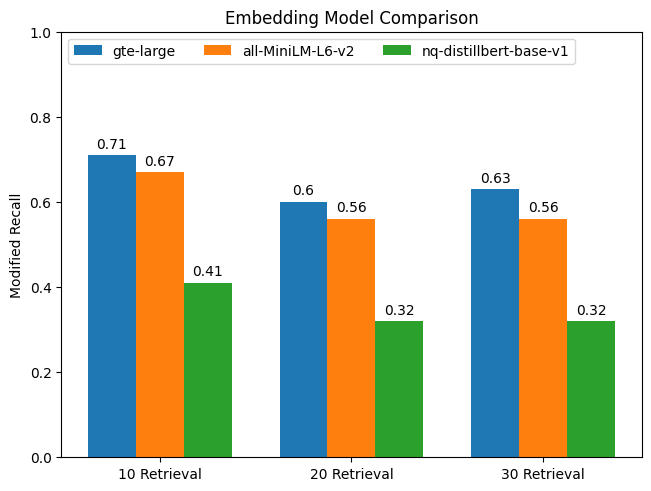

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt
# sns.histplot(data=plot_data, x='10')
xaxis = ("10 Retrieval", "20 Retrieval", "30 Retrieval")
model_evals = {
    'gte-large': (0.71, 0.6, 0.63),
    'all-MiniLM-L6-v2': (0.67, 0.56, 0.56),
    'nq-distillbert-base-v1': (0.41, 0.32, 0.32),
}

x = np.arange(len(xaxis))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_evals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Modified Recall')
ax.set_title('Embedding Model Comparison')
ax.set_xticks(x + width, xaxis)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()


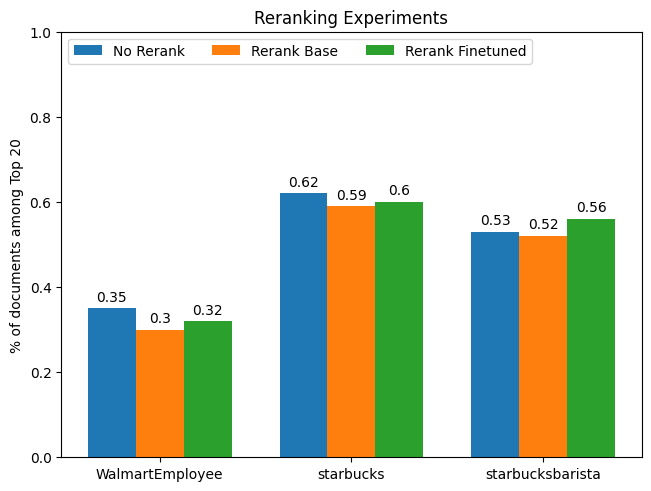

In [ ]:
xaxis = ("WalmartEmployee", "starbucks", "starbucksbarista")
test_evals = {
    'No Rerank': (0.35, 0.62, 0.53),
    'Rerank Base': (0.3, 0.59, 0.52),
    'Rerank Finetuned': (0.32, 0.6, 0.56),
}

x = np.arange(len(xaxis))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in test_evals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of documents among Top 20')
ax.set_title('Reranking Experiments')
ax.set_xticks(x + width, xaxis)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

# Irrelevant search

### Attempt an irrelevant search



In [ ]:
query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
source_information, id_result, score_result = get_search_result_score(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

In [ ]:
query = "I would like to know more about Elon Musk, especially if he really knows anything about AI or not."
source_information, id_result, score_result = get_search_result_score(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

In [ ]:
query = "Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese."
source_information, id_result, score_result = get_search_result_score(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

In [ ]:
query = "你好"
source_information, id_result, score_result = get_search_result_score(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

Query: 你好
Continue to answer the query by using the Search Results:
Text: 🤣🤣🤣[SEP]
Score: 0.953502357006073
Text: 🤦[SEP]
Score: 0.953502357006073
Text: 😂😂😂😂[SEP]
Score: 0.953502357006073
Text: organic celery🪳🪳
Score: 0.9146032929420471
Text: [deleted][SEP]This comment format is overused and stupid. It says nothing.[SEP]
Score: 0.9075616002082825
.


### Compare Embedding Models

In [ ]:
#query = "Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese."
#query = "I would like to know more about Elon Musk, especially if he really knows anything about AI or not."
#query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
#query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."

#context = "🤣🤣🤣[SEP]"
#context = "🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣[SEP]"
#context = "NVIDIA stock share fall by 10 percent in 24 hours today."
#context = "One thing that you should know if you plan on moving up to crew trainer or manager are the three ups"
#context = "You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"
#context = "In simple, you worry about the trash/bathrooms. Stocking them up or keeping them clean or any calls to clean in aisles. Never heard of maintenance to grab carts but maybe that’s your store?[SEP]Yeah that’s why I’m confused because that’s how all of the maintenance people are treated as cart pushers and maintenance. They schedule 1 person on the busiest days and then expect everything to get done but I flat out refuse to stop doing carts or whatever just because they want me to clean 1 tiny spot (happens all the time)[SEP]"

In [ ]:
#embedding_model = SentenceTransformer("thenlper/gte-large")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
def compute_score(query_embed, context_embed):
  score = np.dot(query_embed, context_embed)/(np.linalg.norm(query_embed)*np.linalg.norm(context_embed))
  print(score)

In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.39853414512889485


In [ ]:
query = "Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese."
context = "You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.034370624723985485


In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "🤣🤣🤣[SEP]"

compute_score(get_embedding(query), get_embedding(context))

-0.10583776589115228


In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

-0.08671867602808267


In [ ]:
query = "OK"
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

0.2597539454874249


In [ ]:
query = "你好"
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

0.9020670237354987


In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do。"
context = "You are a cart pusher and janitor essentially🤣🤣🤣. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.38643427964671867


In [ ]:
embedding_model = SentenceTransformer("thenlper/gte-large")
#embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.8671661608450516


In [ ]:
query = "Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese."
context = "You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.7195270193658343


In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "🤣🤣🤣[SEP]"

compute_score(get_embedding(query), get_embedding(context))

0.7628506941934018


In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

0.758397409175602


In [ ]:
query = "OK"
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

0.8106148749981061


In [ ]:
query = "你好"
context = "🤣🤣🤣"

compute_score(get_embedding(query), get_embedding(context))

0.8912411032782247


# Build a chunk directly using Tree structure

In [ ]:
list_df_256_50 = list_df['256,50']

In [ ]:
post_node = list_df_256_50.post[0]
comment_node = list_df_256_50.comment[3]
helper(comment_node)

['In simple, you worry about the trash/bathrooms. Stocking them up or keeping them clean or any calls to clean in aisles. Never heard of maintenance to grab carts but maybe that’s your store?',
 'Yeah that’s why I’m confused because that’s how all of the maintenance people are treated as cart pushers and maintenance. They schedule 1 person on the busiest days and then expect everything to get done but I flat out refuse to stop doing carts or whatever just because they want me to clean 1 tiny spot (happens all the time)',
 'They do that prolly bc they caught on at some point the maintenance crew just does one round around the store and chills for 2 hours. My brother would say he’d literally go around once and then sit in the break room for 2 hours then go around again. Frankly no one really notices them bc they don’t want to. But eventually they caught on. At least at my store. Now there’s only like 2 of them a day']

In [ ]:
# Function to get a post title+text and a single comment section from the given dataframe

def get_post_comment(df, p, c, include_query_text = True):
  #Input:
  #df: dataframe
  #p: index of post in df
  #c: index of comment in post
  #sep_tok: special token to separate the text
  if (p >= len(df)):
    print('Post index exceeds maximum length of dataframe')
    return
  if (c >= len(df.post[p].next)):
    print('Comment index exceeds maximum number of comments')
    return
  post = df.post[p]
  comment = post.next[c]
  comment_list = helper(comment)
  if (include_query_text):
    query = post.title + ' ' + post.text
  else:
    query = post.title
  return query, comment_list

In [ ]:
q, c = get_post_comment(list_df_256_50, 12, 0)

In [ ]:
def to_prompt(prompt, query, context, sep_tok = '[SEP]'):
  text = ''
  for c in context:
    text += c + sep_tok
  return f"Query: {query}\n{prompt}\n{text}."

In [ ]:
prompt = 'Continue to answer the query by using the Search Results:'
combined_info = to_prompt(prompt, q, c)
print(combined_info)

Query: My shift (overnights) got told we had to stay an hour past when we were scheduled or else we’d be pointed because of daylights saving…. All of us were only scheduled from 10-7, our usual. They made us stay until 8. Isn’t that illegal??? 
Continue to answer the query by using the Search Results:
We didn’t have to stay at my store. Overnight left at their usual 7 o’clock but most of took a 30 minute lunch to offset the work and stuff. Our coach told us they couldn’t make us stay anyways because our schedules all said we were done @ 7. Weird that they made y’all stay.[SEP]They didn’t make us stay the last two years so it’s extra weird[SEP]Maybe you've a new lead who doesn't understand how shit works concerning shift length and daylight savings time?


Anyways no they can't point you for leaving after you've worked your hours, and had they pointed you I'd have gone to the people lead to get it removed, then opened doored it if that didn't work.

Since once more they can't keep you p

# Language Models

In [ ]:
!pip install bitsandbytes transformers peft accelerate

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

In [ ]:
def to_prompt(query, context):
  prompt = f"""
  You are an assistant for question-answering tasks.
  Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

  QUESTION: {query}
  =========
  {context}
  """
  return prompt

## Mistral

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

### Use quantized model

In [ ]:
device = "auto" # the device to load the model onto

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
  model_id,
  quantization_config=quantization_config,
  device_map=device
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

### Search database and generate combined info to feed into the model

In [ ]:
db = mongo_client["reddit"]
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

Query: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do.
Continue to answer the query by using the Search Results:
Text: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Text: You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]
Text: U are whatever managers tells u to do u are primary responsibility for cleaning bathrooms, and doing garbage at least that’s what I think I don’t work maintenance[SEP]
Text: In 

In [ ]:
prompt = combined_information

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(combined_information)
print(answer[len(prompt)+4:])

Query: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do.
Continue to answer the query by using the Search Results:
Text: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Text: You are a cart pusher and janitor essentially. You push carts most of the day. Clean the bathrooms, restock the bathrooms, clean spills around the store, and that’s about it.[SEP]
Text: U are whatever managers tells u to do u are primary responsibility for cleaning bathrooms, and doing garbage at least that’s what I think I don’t work maintenance[SEP]
Text: In 

## Llama 2

Same procedure as above

In [ ]:
model_id = "meta-llama/Llama-2-7b-chat-hf"

In [ ]:
device = "auto" # the device to load the model onto

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
  model_id,
  quantization_config=quantization_config,
  device_map=device
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

### Use the get_post_comment to construct a naive prompt

This does not need to use MongoDB

In [ ]:
query, context = get_post_comment(list_df_256_50, 0, 2)
def to_prompt(prompt, query, context, sep_tok = '[SEP]'):
  text = ''
  for c in context:
    text += c + sep_tok
  return f"Query: {query}\n{prompt}\n{text}."
prompt = 'Continue to answer the query by using the Search Results:'
combined_info = to_prompt(prompt, query, context)
print(combined_info)

Query: What does a maintenance associate do???? I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Continue to answer the query by using the Search Results:
In simple, you worry about the trash/bathrooms. Stocking them up or keeping them clean or any calls to clean in aisles. Never heard of maintenance to grab carts but maybe that’s your store?[SEP]Yeah that’s why I’m confused because that’s how all of the maintenance people are treated as cart pushers and maintenance. They schedule 1 person on the busiest days and then expect everything to get done but I flat out refuse to stop doing carts or whatever just because they want me to clean 1 tiny spot (happens all the ti

In [ ]:
prompt = combined_info
print('Length of original inputs', len(prompt))

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')
print('Length of tokenized model_inputs', len(model_inputs[0].tokens))

generated_ids = model.generate(**model_inputs, max_new_tokens=400, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]

Length of original inputs 1412
Length of tokenized model_inputs 353


In [ ]:
print(answer)

<s> Query: What does a maintenance associate do???? I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Continue to answer the query by using the Search Results:
In simple, you worry about the trash/bathrooms. Stocking them up or keeping them clean or any calls to clean in aisles. Never heard of maintenance to grab carts but maybe that’s your store?[SEP]Yeah that’s why I’m confused because that’s how all of the maintenance people are treated as cart pushers and maintenance. They schedule 1 person on the busiest days and then expect everything to get done but I flat out refuse to stop doing carts or whatever just because they want me to clean 1 tiny spot (happens all th

## Llama 3

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:
device = "auto" # the device to load the model onto

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
  model_id,
  quantization_config=quantization_config,
  device_map=device
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = to_prompt(query, source_information)

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>
  You are an assistant for question-answering tasks.
  Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

  QUESTION: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do.
  Text: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Text: You are a cart pusher and janitor essentially. You push carts mos

In [ ]:
query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
prompt = to_prompt(query, source_information)

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>
  You are an assistant for question-answering tasks.
  Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

  QUESTION: I am a football manager and I want to coach a top football team in the future, what should I do now?
  Text: I got lucky and work at a location with good managers.  Good luck with the new job.[SEP]
Text: One thing that you should know if you plan on moving up to crew trainer or manager are the three “ups”

These are Back Up, Clean Up, and Stock Up. I’ll elaborate on each for you.

Back Up is the most important. It basically just means trying your best to clear the line on window or in DT, whether it be taking as many Lane 1 and Lane 2 orders as possible, or opening another register on window. This is the most important because we c

In [ ]:
query = "Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese."
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = to_prompt(query, source_information)

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>
  You are an assistant for question-answering tasks.
  Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

  QUESTION: Homer's Iliad contains a surprising mathematical proof of the Riemann Hypothesis, explain it to me in Japanese.
  Text: 🤣🤣🤣[SEP]
Text: 🤦[SEP]
Text: 😂😂😂😂[SEP]
Text: Front like Tarzan.[SEP]
Text: Proof about the boneless Pattie’s

   Please respond with a summary in Japanese. (Note: Please use the text in the provided source information to answer the question.)


**Response:**


There is no relevant information found in the database.<|eot_id|>


In [ ]:
query = "Can dollartree employee get rehired after leaving?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = to_prompt(query, source_information)

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>
  You are an assistant for question-answering tasks.
  Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

  QUESTION: Can dollartree employee get rehired after leaving?
  Text: Can I come backIf I got no hours from a dollar tree and decided to leave cause I thought they were trying to fire me, can I come back?
Text: But answering your question, I believe you can come back. I believe it depends on the store and SM, a friend of mine left their store but was rehired at a different location and with better hours.[SEP]
Text: Depends if the store manager that did your termination put you as re-hireable.

Typically no notice or incomplete notice = not rehireable ; notice given and worked = rehireable[SEP]
Text: Tell them you found a better opportunity th

## Prompt Engineering

The purpose of this section is the following:
1. Allow LLM to generate better result
2. Enable LLM to determine the relevancy of result itself.
3. etc


## Irrelevant search (Result below is Mistral)

In [ ]:
db = mongo_client["reddit"]
query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
combined_information = (
    f"Query: {query}\nContinue to answer the query by using the Search Results:\n{source_information}."
)

print(combined_information)

In [ ]:
prompt = combined_information

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(answer)

<s> Query: I am a football manager and I want to coach a top football team in the future, what should I do now?
Continue to answer the query by using the Search Results:
Text: I got lucky and work at a location with good managers.  Good luck with the new job.[SEP]
Text: One thing that you should know if you plan on moving up to crew trainer or manager are the three “ups”

These are Back Up, Clean Up, and Stock Up. I’ll elaborate on each for you.

Back Up is the most important. It basically just means trying your best to clear the line on window or in DT, whether it be taking as many Lane 1 and Lane 2 orders as possible, or opening another register on window. This is the most important because we can’t really do much if there are a ton of customers.

Next is clean up. After (or during) a rush, it can get super messy, like spills in lobby or things on the floor in grill. This can create safety hazards so it’s important to make sure you clean up if you have free time before you stock up. 

In [ ]:
query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
prompt = f"""
You are an assistant for question-answering tasks.
Given the following extracted parts of a long document and a question, create a final answer with references ("SOURCES").
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.

QUESTION: {query}
=========
{source_information}
=========
FINAL ANSWER: """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(answer)

<s> 
You are an assistant for question-answering tasks.
Given the following extracted parts of a long document and a question, create a final answer with references ("SOURCES").
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.

QUESTION: I am a football manager and I want to coach a top football team in the future, what should I do now?
Text: I got lucky and work at a location with good managers.  Good luck with the new job.[SEP]
Text: One thing that you should know if you plan on moving up to crew trainer or manager are the three “ups”

These are Back Up, Clean Up, and Stock Up. I’ll elaborate on each for you.

Back Up is the most important. It basically just means trying your best to clear the line on window or in DT, whether it be taking as many Lane 1 and Lane 2 orders as possible, or opening another register on window. This is the most important because we can’t really do much if there are a 

In [ ]:
query = "I am a football manager and I want to coach a top football team in the future, what should I do now?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)
prompt = f"""
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.
QUESTION: {query}
=========
{source_information}
 """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.
QUESTION: I am a football manager and I want to coach a top football team in the future, what should I do now?
Text: I got lucky and work at a location with good managers.  Good luck with the new job.[SEP]
Text: One thing that you should know if you plan on moving up to crew trainer or manager are the three “ups”

These are Back Up, Clean Up, and Stock Up. I’ll elaborate on each for you.

Back Up is the most important. It basically just means trying your best to clear the line on window or in DT, whether it be taking as many Lane 1 and Lane 2 orders as possible, or opening another register on window. This is the most important because we can’t really do much if

**Prompt containing Emoji's might trigger hallucinated response.**

## Relevant search

In [ ]:
query = "What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do."
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = f"""
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: {query}
=========
{source_information}
 """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, only respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do.
Text: What does a maintenance associate do????I got hired as a maintenance associate a few weeks ago and I still have no clue what I’m supposed to do. They say my main thing is pushing carts which makes me think I’m a cart pusher and some of my coworkers talk as if they are different things. But then I have to go to the bathrooms to keep them stocked or do other bullshit things here and there which is super confusing
Text: You are a cart pusher and janitor essentially. You push carts most of the day. Clean t

In [ ]:
query = "I am going to work at Starbucks soon, what should I pay attention to?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = f"""
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: {query}
=========
{source_information}
 """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: I am going to work at Starbucks soon, what should I pay attention to?
Text: Should I move from a cafe starbucks to a corporate starbucks?I currently work in a starbucks within a retail store that serves the same drinks and such, just not owned by the starbucks company. One of those “we proudly serve” type thing. The job requires me to be a barista as well as retail worker within the larger store. I currently am paid minimum wage ($11 an hour in my state). Should I take the opportunity to work at a regular starbucks? I’m afraid to leave my current location and be served with a significantly larger workload. Have any cafe works left to  a starbucks loc

In [ ]:
query = "I ordered a delivery by USPS, it has not arrive for many days, what could possibly happen and what should I do?"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = f"""
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: {query}
=========
{source_information}
 """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: I ordered a delivery by USPS, it has not arrive for many days, what could possibly happen and what should I do?
Text: Buy inventory.[SEP]Brother I'm loaded with inventory. I don't have enough cashiers, loaders, delivery trucks, or salesmen to move it all.[SEP]It’s not inventory. Spring inventory was bought months ago. Even if the order was placed today there is no way it could be manufactured and shipped overseas and make it through the supply chain for this spring.[SEP]
Text: The issue is the driver who picks up the opened mattress instead of refusing it. Once it gets back to the hub there's usually nothing that can be done but keep sending it on it

In [ ]:
query = "Has anyone gotten hired by lowes already? What's there experiences at Lowes"
source_information, id_result = get_search_result(query, db['reddit_collection_256_50'], 'reddit_collection_256_50', 5)

prompt = f"""
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: {query}
=========
{source_information}
 """

model_inputs = tokenizer([prompt], return_tensors="pt").to('cuda')
#model.to('cuda')

generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=True)
answer = tokenizer.batch_decode(generated_ids)[0]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
You are an assistant for question-answering tasks.
Given the following query and source information: If the source information does not provides anything helpful to the query, ONLY respond with the following: 'There is no relevant information found in the database.' If the source information is relevant, summarize it below.

QUESTION: Has anyone gotten hired by lowes already? What's there experiences at Lowes
Text: Lowe's is defo one of those, *made for some, not for others* type jobs. Congrats on getting hired![SEP]
Text: Doesn’t surprise me. I have never once had a good experience with Lowe’s when dealing with Corporate. I will never shop at a Lowe’s store again due to how incompetent corporate is. I work in the public school system as a custodian and Lowe’s corporate makes my bosses look good which isn’t a good thing.[SEP]
Text: Just got hired.Hi, all. I just got hired on for part-time in lumber. I've seen the posts about a lot of people hating Lowe's. I'm fortunate enough to b